### Continuous Fourier Transform & FFT

\begin{aligned}
\hat{f}\left(k\right) &=\frac{1}{\sqrt{2\pi}}\int f\left(x\right)e^{-ikx}dx\approx\frac{1}{\sqrt{2\pi}}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-ikj\Delta x}\Delta x \\
	&=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\sqrt{2\pi}kj\frac{\Delta x}{\sqrt{2\pi}}}\frac{\Delta x}{\sqrt{2\pi}}\to f\left(k_{n}\right)=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\sqrt{2\pi}\left(n\frac{2\pi}{N\Delta x}\right)j\frac{\Delta x}{\sqrt{2\pi}}}\frac{\Delta x}{\sqrt{2\pi}} \\
	&=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\frac{\Delta x}{\sqrt{2\pi}} \\
	&=\frac{L}{\sqrt{2\pi N}}\left[\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\right] \\
	&=\frac{L}{\sqrt{2\pi}}\left[\frac{1}{N}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\right]
\end{aligned}

If $L=1, \hat{f}\left(k\right)=\frac{1}{\sqrt{2\pi N}}\text{fft}_{\text{ortho}}\left(f\right)=\frac{1}{\sqrt{2\pi}}\text{fft}_{\text{forward}}\left(f\right)=\frac{1}{\sqrt{2\pi}N}\text{fft}_{\text{backward}}\left(f\right)$.

In Numpy FFT lib, the **default** normalization ("backward") has the direct (forward) transforms unscaled and the inverse (backward) transforms scaled by $\frac{1}{N}$. For normalization "ortho" both direct and inverse transforms are scaled by $\sqrt{N}$. For normalization "forward" the direct transforms scaled by $\frac{1}{N}$ and the inverse transforms unscaled.

For even $N$, Nyquist frequency is at index $N/2$ (negative);

For odd $N$, index $\frac{N-1}{2}$ denotes the largest positive frequency, while $\frac{N+1}{2}$ denotes the largest negative frequency (absolute value here). 

The index $k<\frac{N}{2}$ corresponds to a positive frequency $\frac{k}{N}$, the index $k\ge\frac{N}{2}$ corresponds to a negative frequency $\frac{k-N}{N}$

In [1]:
import numpy as np
from numpy import fft

#### examples for the FFT module ####
N = 10
k_fft = fft.fftfreq(N)*2*np.pi  # Nyquist frequency = \pi, one period = 2\pi
print(k_fft)
N = 11
k_fft = fft.fftfreq(N)*2*np.pi  # Nyquist frequency = \pi, one period = 2\pi
print(k_fft)
print(k_fft.conjugate())

[ 0.          0.62831853  1.25663706  1.88495559  2.51327412 -3.14159265
 -2.51327412 -1.88495559 -1.25663706 -0.62831853]
[ 0.          0.57119866  1.14239733  1.71359599  2.28479466  2.85599332
 -2.85599332 -2.28479466 -1.71359599 -1.14239733 -0.57119866]
[ 0.          0.57119866  1.14239733  1.71359599  2.28479466  2.85599332
 -2.85599332 -2.28479466 -1.71359599 -1.14239733 -0.57119866]


### Contour Fitting Function

In [2]:
##  Plot Fluctuating Flat Interface ##
import yt
import numpy as np
from skimage import measure

def ih_direct(profile, level = 0):
    """
    Calculates the interface height in the z-direction for a system with a flat interface across the xy plane.

    This function determines the z-coordinate of the interface at each point in the xy plane by identifying where the isocontour of the interface is zero. It uses the `skimage.measure.find_contours` function to perform this calculation.

    Parameters
    ----------
    profile : numpy.ndarray
        A 3D NumPy array representing the order parameter of the system. The array has dimensions `(nx, ny, nz)`, where `nx` is the size in the x-direction and `ny` and `nz` are the sizes in the y- and z-directions, respectively.
           
           z (height)
           |
     _ _ _ |_ _ _ _ _ _ _ _ 
           |__ __ __ y (stripe length)
     _ _ _/__ _ _ _ _ _ _ _ 
         /
        /
       x (thickness of the interface is in the x-direction)
    """
    nx, ny, nz = profile.shape
    index_levels = np.arange(0, ny, 1)
    out = np.zeros((nx, ny))
    for x in range(nx):
        levels = measure.find_contours(profile[x, :, :], level = level)[1]
        #print(levels)
        idxs = np.isin(levels[:, 0], index_levels)
        #print(idxs.shape)
        out[x,:] = levels[idxs, 1]
        #print(out[x].shape)
    return out

# Example usage
alpha0 = 1.5
temperature = 0.
nx = 8
ny = 256
nz = 64
frameIdx = 2000
rho_lo = 0.1
rho_hi = 2.

file_path = "./data_interface_alpha0_{:.2f}/lbm_data_shshan_alpha0_".format(alpha0) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}/".format(nx, ny, nz) + "plt" + f"{frameIdx:07d}"
ts = yt.load(file_path)
profile_data = ts.covering_grid(
    level=0, left_edge=ts.domain_left_edge, dims=ts.domain_dimensions
)
print(ts.field_list)
profile = profile_data['boxlib', 'rho']
print("input data has shape ", profile.shape)

height = ih_direct(profile, (rho_lo + rho_hi)/2.)
print(height)

yt : [INFO     ] 2025-11-14 02:38:00,475 Parameters: current_time              = 2000.0
yt : [INFO     ] 2025-11-14 02:38:00,475 Parameters: domain_dimensions         = [  8 256  64]
yt : [INFO     ] 2025-11-14 02:38:00,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-14 02:38:00,476 Parameters: domain_right_edge         = [1. 1. 1.]


[('boxlib', 'afx'), ('boxlib', 'afy'), ('boxlib', 'afz'), ('boxlib', 'agx'), ('boxlib', 'agy'), ('boxlib', 'agz'), ('boxlib', 'nfbarx'), ('boxlib', 'ngbarx'), ('boxlib', 'p_bulk'), ('boxlib', 'phi'), ('boxlib', 'rho'), ('boxlib', 'ubx'), ('boxlib', 'uby'), ('boxlib', 'ubz'), ('boxlib', 'ufbarx'), ('boxlib', 'ufx'), ('boxlib', 'ufy'), ('boxlib', 'ufz'), ('boxlib', 'ugbarx'), ('boxlib', 'ugx'), ('boxlib', 'ugy'), ('boxlib', 'ugz')]
input data has shape  (8, 256, 64)
[[47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]
 [47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]
 [47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]
 ...
 [47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]
 [47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]
 [47.86628666 47.86628666 47.86628666 ... 47.86628666 47.86628666
  47.86628666]]


### Spectrum of height fluctuations $h$ of a flat interface

$$\left\langle \left|\hat{h}\left(k\right)\right|^{2}\right\rangle =\frac{k_{B}T}{C^2_{invf}\gamma k^{2}}$$

##### Proof

Free energy of fluctuating flat interface
$$F=\gamma S$$
in which $S$ denotes surface area. The surface area element is ($\bm{r}=\left(x,y,h(x,y)\right)$, standard parametric form of a surface)
\begin{aligned}
S	=\int\left|\frac{\partial\bm{r}}{\partial x}\times\frac{\partial\bm{r}}{\partial y}\right|dxdy=\int\left|\begin{array}{ccc}
\bm{i} & \bm{j} & \bm{k}\\
1 & 0 & \frac{\partial h}{\partial x}\\
0 & 1 & \frac{\partial h}{\partial y}
\end{array}\right|dxdy
	=\int\left|-\frac{\partial h}{\partial x}\bm{i}-\frac{\partial h}{\partial y}\bm{j}+\bm{k}\right|dxdy
	=\int\sqrt{1+\left|\nabla h\left(x,y\right)\right|^{2}}dxdy
\end{aligned}

Therefore the free energy is
\begin{aligned}
\Delta F&=\gamma\Delta S\approx\frac{\gamma}{2}\int\left|\nabla h\left(x,y\right)\right|^{2}dxdy\\&=\frac{\gamma}{2}\int C_{inv}^{2}\left[\nabla\int\hat{h}\left(\bm{k}\right)e^{i\bm{k}\cdot\bm{r}}d\bm{k}\cdot\nabla\int\hat{h}^{*}\left(\bm{k}^{\prime}\right)e^{-i\bm{k}^{\prime}\cdot\bm{r}}d\bm{k}^{\prime}\right]dxdy\\&=\frac{\gamma}{2}\int C_{inv}^{2}\left[i\bm{k}\int\hat{h}\left(\bm{k}\right)e^{i\bm{k}\cdot\bm{r}}d\bm{k}\cdot\left(-i\right)\bm{k}^{\prime}\int\hat{h}^{*}\left(\bm{k}^{\prime}\right)e^{-i\bm{k}^{\prime}\cdot\bm{r}}d\bm{k}^{\prime}\right]dxdy\\&=\frac{\gamma}{2}C_{inv}^{2}\int\left[\int\bm{k}\cdot\bm{k}^{\prime}\hat{h}\left(\bm{k}\right)\hat{h}^{*}\left(\bm{k}^{\prime}\right)e^{i\left(\bm{k}-\bm{k}^{\prime}\right)\cdot\bm{r}}d\bm{k}d\bm{k}^{\prime}\right]d\bm{r}\\&=\frac{\gamma}{2}C_{inv}^{2}\iint\bm{k}\cdot\bm{k}^{\prime}\hat{h}\left(\bm{k}\right)\hat{h}^{*}\left(\bm{k}^{\prime}\right)\left[\int e^{i\left(\bm{k}-\bm{k}^{\prime}\right)\cdot\bm{r}}\right]d\bm{r}d\bm{k}d\bm{k}^{\prime}\\&=\frac{\gamma}{2}C_{inv}^{2}\left(2\pi\right)^{d}\iint\delta\left(\bm{k}-\bm{k}^{\prime}\right)\bm{k}\cdot\bm{k}^{\prime}\hat{h}\left(\bm{k}\right)\hat{h}^{*}\left(\bm{k}^{\prime}\right)d\bm{k}d\bm{k}^{\prime}\\&=\frac{\gamma}{2}C_{inv}^{2}\left(2\pi\right)^{d}\int\left|\bm{k}\right|^{2}\left|\hat{h}\left(\bm{k}\right)\right|^{2}d\bm{k}
\end{aligned}

By FDT, $Z\sim e^{-\beta\Delta F}$, each ~$\left|\hat{h}\left(\bm{k}\right)\right|^2$ term possesses $\frac{k_BT}{2}$. Using $\int_{-\infty}^{\infty}e^{-\alpha x^{2}}dx=\sqrt{\frac{\pi}{\alpha}},\int_{-\infty}^{\infty}x^{2}e^{-\alpha x^{2}}dx=\frac{1}{2\alpha}\sqrt{\frac{\pi}{\alpha}}$ we have
$$Z\sim e^{-\beta\Delta F}=e^{-\alpha\left|\hat{h}\left(\bm{k}\right)\right|^{2}},\ \ \alpha:=\beta\frac{\gamma}{2}C_{inv}^{2}\left(2\pi\right)^{d}\left|\bm{k}\right|^{2}$$
$$\left\langle \left|\hat{h}\left(\bm{k}\right)\right|^{2}\right\rangle =\int\frac{\left|\hat{h}\left(\bm{k}\right)\right|^{2}e^{-\alpha\left|\hat{h}\left(\bm{k}\right)\right|^{2}}d\hat{h}_{r}d\hat{h}_{i}}{\int e^{-\alpha\left|\hat{h}\left(\bm{k}\right)\right|^{2}}d\hat{h}_{r}d\hat{h}_{i}}=\frac{\int\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)e^{-\alpha\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)}d\hat{h}_{r}d\hat{h}_{i}}{\int e^{-\alpha\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)}d\hat{h}_{r}d\hat{h}_{i}}$$
$$\int e^{-\alpha\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)}d\hat{h}_{r}d\hat{h}_{i}=\left(\sqrt{\frac{\pi}{\alpha}}\right)^{2}=\frac{\pi}{\alpha}$$

\begin{aligned}
\int\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)e^{-\alpha\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)}d\hat{h}_{r}d\hat{h}_{i}&=2\int\hat{h}_{r}^{2}e^{-\alpha\left(\hat{h}_{r}^{2}+\hat{h}_{i}^{2}\right)}d\hat{h}_{r}d\hat{h}_{i}\\&=2\frac{1}{2\alpha}\sqrt{\frac{\pi}{\alpha}}\cdot\sqrt{\frac{\pi}{\alpha}}=\frac{1}{\alpha}\cdot\frac{\pi}{\alpha}
\end{aligned}

$$\left\langle \left|\hat{h}\left(\bm{k}\right)\right|^{2}\right\rangle =\frac{\frac{1}{\alpha}\cdot\frac{\pi}{\alpha}}{\frac{\pi}{\alpha}}=\frac{1}{\alpha}=\frac{2k_{B}T}{C_{invf}^{2}\gamma\left|\bm{k}\right|^{2}}$$
$$\to\ \ \ \ \left\langle \left|\hat{h}\left(\bm{k}\right)\right|^{2}\right\rangle =\frac{k_{B}T}{C_{invf}^{2}\gamma\left|\bm{k}\right|^{2}}$$


### ensemble average for $\left\langle \left|\hat{h}\left(k\right)\right|^{2}\right\rangle$


In [3]:
###   Read in height ensembles from step1 to step2 ###

step1 = 500000
step2 = 800000
plot_int = 2000 # interval between frames
alpha0 = 1.5
temperature = 1e-5
nx = 8
ny = 256
nz = 64
rho_lo = 0.1
rho_hi = 3.

sliceIdx_x = 4
height_arrays = np.zeros(((step2 - step1) // plot_int + 1, ny))
for n in range(step1, step2+plot_int, plot_int):
    plot_file_dir = "./data_interface_alpha0_{:.2f}/lbm_data_shshan_alpha0_".format(alpha0) + "{:.2f}".format(alpha0) +\
          "_xi_" + "{:.1e}".format(temperature) + "_size{:d}-{:d}-{:d}_continue/".format(nx, ny, nz) + "plt" + f"{n:07d}"
    ds = yt.load(plot_file_dir)
    profile = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    profile_data = profile['boxlib', 'rho']
    height = ih_direct(profile_data, (rho_lo + rho_hi)/2.)
    height_arrays[(n - step1) // plot_int, :] = height[sliceIdx_x, :]

print(height_arrays)


yt : [INFO     ] 2025-11-14 02:38:00,956 Parameters: current_time              = 500000.0
yt : [INFO     ] 2025-11-14 02:38:00,956 Parameters: domain_dimensions         = [  8 256  64]
yt : [INFO     ] 2025-11-14 02:38:00,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-14 02:38:00,957 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-11-14 02:38:01,430 Parameters: current_time              = 502000.0
yt : [INFO     ] 2025-11-14 02:38:01,430 Parameters: domain_dimensions         = [  8 256  64]
yt : [INFO     ] 2025-11-14 02:38:01,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-14 02:38:01,431 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-11-14 02:38:02,066 Parameters: current_time              = 504000.0
yt : [INFO     ] 2025-11-14 02:38:02,066 Parameters: domain_dimensions         = [  8 256  64]
yt : [INFO     ] 2025-11-14 02:38:02,067 Parameters: domain_left_edge        

[[47.53570537 47.52673451 47.53271878 ... 47.54128628 47.53617697
  47.53497365]
 [47.53234371 47.54138341 47.54075096 ... 47.5426316  47.54187693
  47.54473525]
 [47.55310764 47.54283981 47.53731994 ... 47.54661281 47.55395241
  47.55204681]
 ...
 [47.50269865 47.50510896 47.50355954 ... 47.50606832 47.50786671
  47.5078537 ]
 [47.50941065 47.51284224 47.50649261 ... 47.50986521 47.5024722
  47.50348529]
 [47.52624804 47.53308584 47.52821132 ... 47.52843713 47.527398
  47.53232114]]


### Illustration for the selection of the FFT mode

From above in order to set $C_{invf} = 1$, we need to choose the Fourier Transform as
\begin{aligned}
\hat{f}\left(k\right) &=\frac{1}{2\pi}\int f\left(x\right)e^{-ikx}dx\approx\frac{1}{2\pi}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-ikj\Delta x}\Delta x \\
\to f\left(k_{n}\right)&=\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\sqrt{2\pi}\left(n\frac{2\pi}{N\Delta x}\right)j\frac{\Delta x}{\sqrt{2\pi}}}\frac{\Delta x}{\sqrt{2\pi}} \\
 &=\frac{L}{\sqrt{2\pi}}\left[\frac{1}{N}\sum_{j=0}^{N-1}f\left(x_{j}\right)e^{-i\frac{2\pi nj}{N}}\right]
\end{aligned}

[ 0.          0.00390625  0.0078125   0.01171875  0.015625    0.01953125
  0.0234375   0.02734375  0.03125     0.03515625  0.0390625   0.04296875
  0.046875    0.05078125  0.0546875   0.05859375  0.0625      0.06640625
  0.0703125   0.07421875  0.078125    0.08203125  0.0859375   0.08984375
  0.09375     0.09765625  0.1015625   0.10546875  0.109375    0.11328125
  0.1171875   0.12109375  0.125       0.12890625  0.1328125   0.13671875
  0.140625    0.14453125  0.1484375   0.15234375  0.15625     0.16015625
  0.1640625   0.16796875  0.171875    0.17578125  0.1796875   0.18359375
  0.1875      0.19140625  0.1953125   0.19921875  0.203125    0.20703125
  0.2109375   0.21484375  0.21875     0.22265625  0.2265625   0.23046875
  0.234375    0.23828125  0.2421875   0.24609375  0.25        0.25390625
  0.2578125   0.26171875  0.265625    0.26953125  0.2734375   0.27734375
  0.28125     0.28515625  0.2890625   0.29296875  0.296875    0.30078125
  0.3046875   0.30859375  0.3125      0.31640625  0

/tmp/ipykernel_2055072/3355298993.py:21: RuntimeWarning: divide by zero encountered in divide
  ky_fft2_inv = 1./(ky_fft*ky_fft.conjugate())
/usa/xdengae/.conda/envs/amrex_env/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usa/xdengae/.conda/envs/amrex_env/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


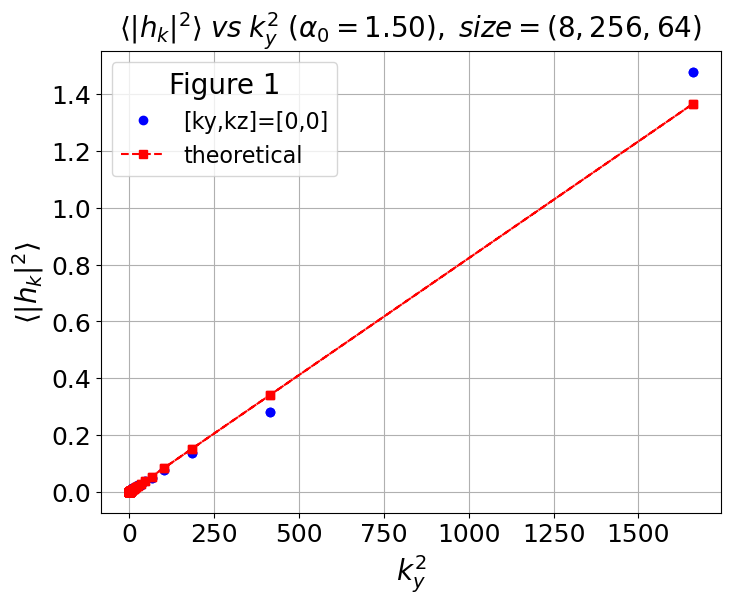

In [4]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 20,           # General font size
    'axes.titlesize': 20,      # Axes title
    'axes.labelsize': 20,      # Axes labels
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 16,     # Legend
    'figure.titlesize': 18     # Figure title
})

fft_mode = "backward"  # Normalization mode for FFT
gamma = 0.012162 # Surface tension


h_k_norm2 = np.zeros((ny), dtype = np.complex128)
ky_fft = fft.fftfreq(ny)*2*np.pi
print(fft.fftfreq(ny))
ky_fft2_inv = 1./(ky_fft*ky_fft.conjugate())
h_mean = np.mean(height_arrays, axis=0)  # Mean height profile across the ensemble

# height_arrays = np.zeros(((step2 - step1) // plot_int + 1, ny))
for n in range(height_arrays.shape[0]):
    h = height_arrays[n, :] - h_mean
    h_k = fft.fft(h, norm = fft_mode)
    h_k_norm2 += h_k*h_k.conjugate()
h_k_norm2 /= height_arrays.shape[0]  # Average over the ensemble

plt.figure(1, figsize=(8, 6), dpi=100)  # Optional: Set the figure size
#fig, ax = plt.subplots()
plt.plot(ky_fft2_inv, h_k_norm2, label="[ky,kz]=[0,0]", marker='o', linestyle='', color='b') 
# Second plot
plt.plot(ky_fft2_inv, temperature*ky_fft2_inv/gamma,
         label="theoretical", marker='s', linestyle='--', color='r')
plt.legend(title="Figure 1")

plt.xlabel(r"$k_y^2$")  # X-axis label
plt.ylabel(r"$\langle |h_k|^2 \rangle$")  # Y-axis label
plt.title(r"$\langle |h_k|^2 \rangle \; vs\; k_y^2 \; (\alpha_0={:.2f}), \; size=({:d},{:d},{:d})$".format(alpha0, nx, ny, nz))
#plt.ylim(0,1.2)
plt.grid(True)


/tmp/ipykernel_2055072/4139198655.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ky_fft), np.log(h_k_norm2), label="[ky,kz]=[0,0]", marker='o', linestyle='', color='b')
/tmp/ipykernel_2055072/4139198655.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ky_fft), np.log(h_k_norm2), label="[ky,kz]=[0,0]", marker='o', linestyle='', color='b')
/tmp/ipykernel_2055072/4139198655.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ky_fft), np.log(temperature*ky_fft2_inv/gamma),
/tmp/ipykernel_2055072/4139198655.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ky_fft), np.log(temperature*ky_fft2_inv/gamma),


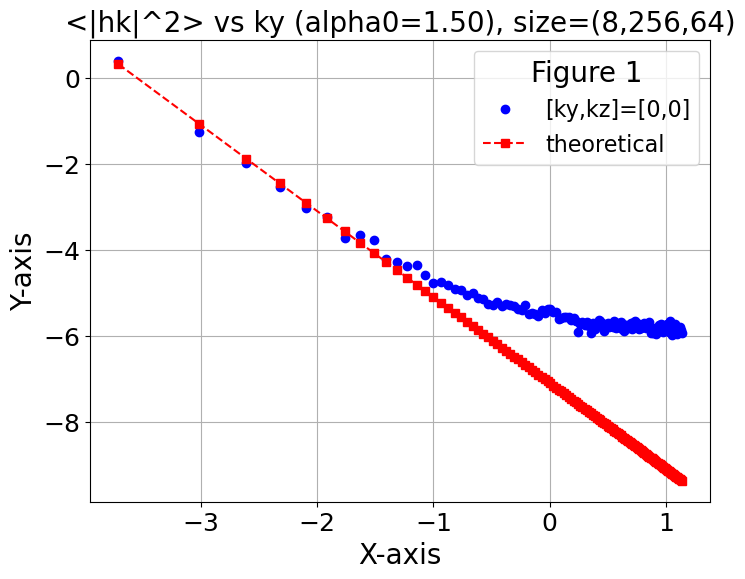

In [5]:
plt.figure(1, figsize=(8, 6), dpi=100)  # Optional: Set the figure size
#fig, ax = plt.subplots()
plt.plot(np.log(ky_fft), np.log(h_k_norm2), label="[ky,kz]=[0,0]", marker='o', linestyle='', color='b') 
# Second plot
plt.plot(np.log(ky_fft), np.log(temperature*ky_fft2_inv/gamma),
         label="theoretical", marker='s', linestyle='--', color='r')
plt.legend(title="Figure 1")

plt.xlabel("X-axis")  # X-axis label
plt.ylabel("Y-axis")  # Y-axis label
plt.title("<|hk|^2> vs ky (alpha0={:.2f}), size=({:d},{:d},{:d})".format(alpha0,nx,ny,nz))  # Plot title
#plt.ylim(0,1.2)
plt.grid(True)